In [ ]:
# test max

In [1]:
path_antoine = "/Users/antoine/Documents/ENSAE2A/Codeperso/everything/Statappperso/Ressources/"
path_results_antoine = "/Users/antoine/Documents/ENSAE2A/Codeperso/everything/Statappperso/Ressources/Results/"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from Tool_Functions.cleaning_data import *
from Tool_Functions.join_data import *
from Tool_Functions.test_comportment_reabo import *
from Tool_Functions.visual import *
from Tool_Functions.comportment_reabo import *

In [3]:
from sklearn.cluster import KMeans  # Import KMeans clustering algorithm
from sklearn.metrics import silhouette_samples, silhouette_score  # Import silhouette metrics

import matplotlib.cm as cm  # Import colormap for visualizations
import matplotlib.pyplot as plt  # Import plotting library
import numpy as np  

from matplotlib.backends.backend_pdf import PdfPages  # Import PdfPages for saving plots to PDF


In [27]:
df = file_to_dataframe(path_antoine + 'fusion_table_score_v1.csv')

In [28]:
df.columns

Index(['ID_ABONNE', 'Autres_n_REABOS', 'ODD 15 jours EV+_n_REABOS',
       'ODD 15 jours TC_n_REABOS', 'ODD 21 jours TC_n_REABOS',
       'ODD 30 jours EV+_n_REABOS', 'ODD 30 jours TC_n_REABOS',
       'ODD 7 jours autre que SG_n_REABOS', 'PAS_ODD_n_REABOS',
       'Semaine genéreuse_n_REABOS', 'PAS_ODD_MEAN_TIME', 'MOY_DELAI',
       'NB_APPARITIONS', 'Autres_MEAN_TIME_DIFF',
       'ODD 15 jours EV+_MEAN_TIME_DIFF', 'ODD 15 jours TC_MEAN_TIME_DIFF',
       'ODD 21 jours TC_MEAN_TIME_DIFF', 'ODD 30 jours EV+_MEAN_TIME_DIFF',
       'ODD 30 jours TC_MEAN_TIME_DIFF',
       'ODD 7 jours autre que SG_MEAN_TIME_DIFF', 'PAS_ODD_MEAN_TIME_DIFF',
       'Semaine genéreuse_MEAN_TIME_DIFF', 'Autres_n_REABOS_POURCENTAGE',
       'ODD 15 jours EV+_n_REABOS_POURCENTAGE',
       'ODD 15 jours TC_n_REABOS_POURCENTAGE',
       'ODD 21 jours TC_n_REABOS_POURCENTAGE',
       'ODD 30 jours EV+_n_REABOS_POURCENTAGE',
       'ODD 30 jours TC_n_REABOS_POURCENTAGE',
       'ODD 7 jours autre que SG_n_REABO

In [4]:

# Scales the data set

def cluster_data_set_pourc(filename, columns, change_inf=np.nan, change_nan=15):
    """
    Load a dataset, perform clustering, and return clustered data.

    Args:
    - filename: Name of the file containing the data.
    - columns: List of column names to include in clustering.
    - change_inf: Value to use for replacing infinity.
    - change_nan: Value to use for replacing NaN.

    Returns:
    - data: DataFrame containing clustered data.
    """
    # Load the dataset from file
    df = file_to_dataframe(filename)
    
    # Select the specified columns
    data = df[columns]
    
    # Replace infinite values with specified value
    data.replace([np.inf, -np.inf], change_inf, inplace=True)

    # Normalize the data
    scaler = StandardScaler()
    datas = scaler.fit_transform(data)
    data = pd.DataFrame(datas, columns=data.columns)

    # Select a random 10% sample of the data
    indices = np.random.choice(range(len(data)), size=int(len(data) * 0.1), replace=False)
    data = data.iloc[indices]

    # Replace NaN values with specified value
    data.replace(np.nan, change_nan, inplace=True)

    return data


In [5]:

# Scales the data set

def cluster_data_set(filename, columns, change_inf=np.nan, change_nan=15):
    """
    Load a dataset, perform clustering, and return clustered data.

    Args:
    - filename: Name of the file containing the data.
    - columns: List of column names to include in clustering.
    - change_inf: Value to use for replacing infinity.
    - change_nan: Value to use for replacing NaN.

    Returns:
    - data: DataFrame containing clustered data.
    """
    # Load the dataset from file
    df = file_to_dataframe(filename)
    
    # Select the specified columns
    data = df[columns]
    
    # Replace infinite values with specified value
    data.replace([np.inf, -np.inf], change_inf, inplace=True)

    # Normalize the data
    scaler = StandardScaler()
    datas = scaler.fit_transform(datas)
    data = pd.DataFrame(datas, columns=data.columns)

    # Select a random 10% sample of the data

    # Replace NaN values with specified value
    data.replace(np.nan, change_nan, inplace=True)

    return data


In [6]:
# Après avoir utilisé KMeans et avoir obtenu clusters = ...

def data_frame_cluster(data, columns, centers_inv, clusters, data_id_abo):
    """
    Create a DataFrame containing clusters, cluster centers, and subscriber IDs.

    Args:
    - data: DataFrame containing the data.
    - columns: List of column names.
    - centers_inv: Inverse cluster centers (denormalized).
    - clusters: Cluster number assigned to each sample.
    - data_id_abo: DataFrame containing subscriber IDs.

    Returns:
    - df_clusters: DataFrame containing clusters, centers, and percentage IDs.
    """

    datas = data.copy()
    # Add cluster labels and subscriber IDs to the data
    datas['KMEANS'] = clusters
    datas['ID_ABONNE'] = data_id_abo['ID_ABONNE']

    # Generate DataFrame with cluster information
    df_clusters = percent_abo_conditions(datas, 'KMEANS', 'ID_ABONNE')
    df_clusters = df_clusters.sort_values(by='KMEANS')

    # Round and assign cluster centers to the DataFrame
    centers = np.round(centers_inv, decimals=2)
    for j in range(len(columns)):
        df_clusters[columns[j]] = [centers[i][j] for i in range(len(centers))]

    return df_clusters


In [8]:
def visualize_silhouette_datas_all(filename, columns, range_n_clusters, data_path_results, change_inf=np.nan, change_nan=15):
    """
    Visualize silhouette scores for different numbers of clusters.

    Args:
    - filename: Name of the file containing the data.
    - columns: List of column names to include in clustering.
    - range_n_clusters: List of numbers of clusters to test.
    - data_path_results: Path to save the results.
    - change_inf: Value to use for replacing infinity.
    - change_nan: Value to use for replacing NaN.

    Returns:
    - silhouette_scores: List of silhouette scores.
    """
    # Load the dataset from file
    df = file_to_dataframe(filename)
    data = df[columns]
    
    # Replace infinite values with specified value
    data.replace([np.inf, -np.inf], change_inf, inplace=True)

    # Normalize the data
    scaler = StandardScaler()
    datas = scaler.fit_transform(data)

    data = pd.DataFrame(datas, columns=data.columns)

    # Select a random 10% sample of the data
    indices = np.random.choice(range(len(data)), size=int(len(data) * 0.1), replace=False)
    data = data.iloc[indices]
    data_id_abo = df[['ID_ABONNE']].iloc[indices]   

    # Replace NaN values with specified value
    data.replace(np.nan, change_nan, inplace=True)

    silhouette_scores = []

    with PdfPages(data_path_results + "silhouettes_scores_reu.pdf") as pdf:
        for n_clusters in range_n_clusters:

            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer = KMeans(n_clusters, random_state=10)
            clusterer.fit(data)

            centers = clusterer.cluster_centers_
            centers_cluster = np.round(scaler.inverse_transform(centers), decimals=2)

            # Create DataFrame with cluster information
            df_cluster = data_frame_cluster(data, columns, scaler.inverse_transform(centers),
                                             clusterer.labels_, data_id_abo)
            
            # Write cluster DataFrame to Excel
            save_to_csv_file(df_cluster, data_path_results + "cluster_reu" + str(n_clusters) + ".csv")

            cluster_labels = clusterer.fit_predict(data)

            silhouette_avg = silhouette_score(data, cluster_labels)

            silhouette_scores.append(silhouette_avg)

            print(
                "For n_clusters =", n_clusters,
                "The average silhouette_score is :", silhouette_avg,
            )

            fig, ax1 = plt.subplots(1, 1)
            fig.set_size_inches(9, 7)

            ax1.set_xlim([-0.1, 1])
            ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

            y_lower = 10
            sample_silhouette_values = silhouette_samples(data, cluster_labels)

            for i in range(n_clusters):

                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
                ith_cluster_silhouette_values.sort()
                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i
                color = cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color,
                                  edgecolor=color, alpha=0.7)
                ax1.text(-0.8, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10

            ax1.set_title("The silhouette plot for the various clusters." + str(n_clusters))
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])
            ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

            pdf.savefig(fig)
            plt.close(fig)

    return silhouette_scores


In [10]:
def trace_silhouette_scores(silhouette_scores, abscisses):

    plt.figure(figsize=(8, 6))
    plt.plot(abscisses, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('KMeans Silhouette Score')
    plt.title('Silhouette Score for Different Numbers of Clusters')
    plt.show()

    plt.xticks(abscisses)

    return True

/var/folders/md/_fklkl9s1z9gj6bpnwj204y40000gn/T/ipykernel_23996/3297560888.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace([np.inf, -np.inf], change_inf, inplace=True)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 The average silhouette_score is : 0.4911971283412065


/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3 The average silhouette_score is : 0.39806753663747396


/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.40757320714291695


/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5 The average silhouette_score is : 0.36335453395812617


/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.3304699170362005


/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7 The average silhouette_score is : 0.32560731621334904


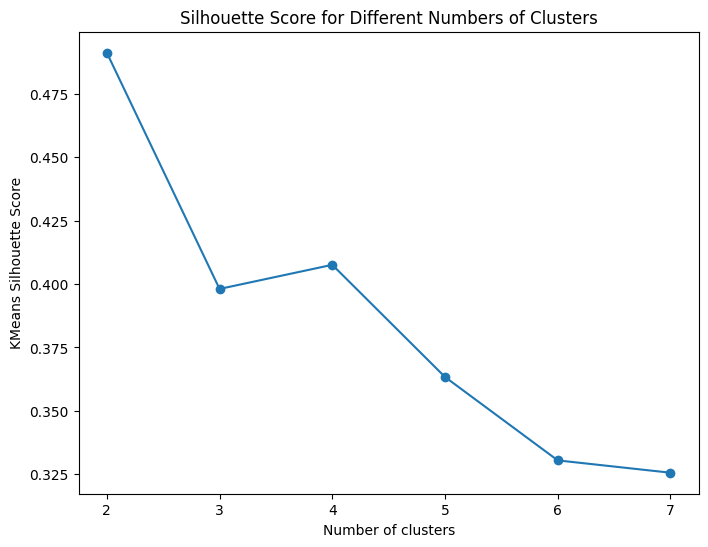

True

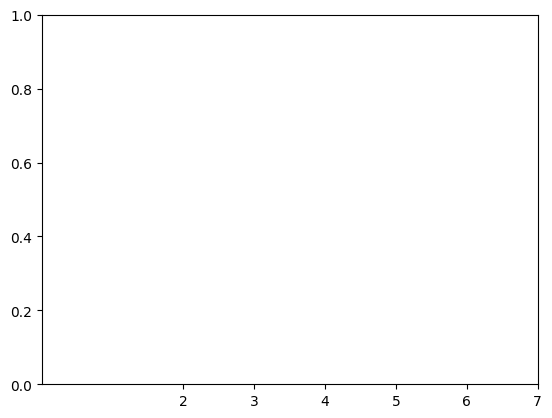

In [11]:
trace_silhouette_scores(visualize_silhouette_datas_all(path_antoine + "fusion_table_score_v1.csv",
                                                       ['ODD 15 jours TC_n_REABOS','Semaine genéreuse_n_REABOS', 'SCORE_FIDELITE'],
                                                       [2, 3, 4, 5, 6, 7],
                                                       path_antoine + "Clustering_results/"), [2, 3, 4, 5, 6, 7])

/var/folders/md/_fklkl9s1z9gj6bpnwj204y40000gn/T/ipykernel_17722/3053019320.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace([np.inf, -np.inf], change_inf, inplace=True)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5 The average silhouette_score is : 0.39283938342436076


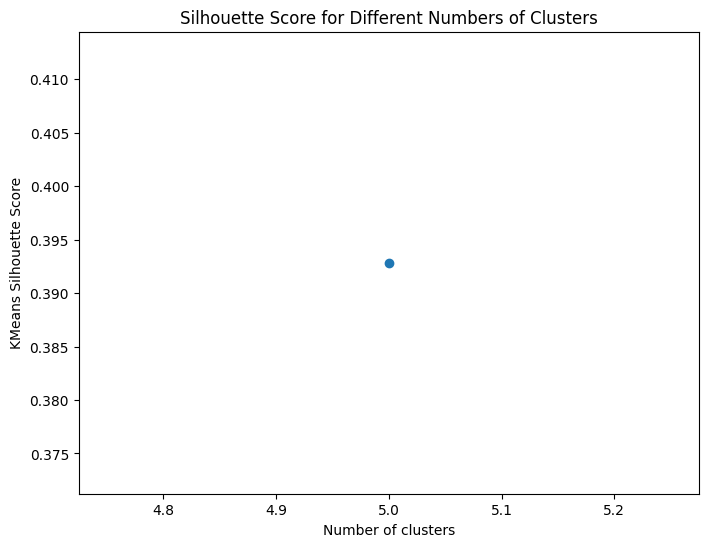

True

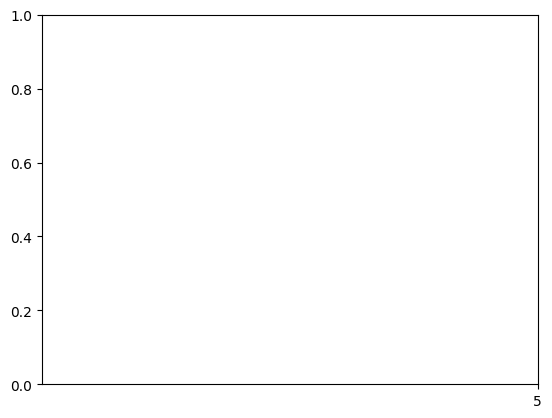

In [23]:
trace_silhouette_scores(visualize_silhouette_datas_all(path_antoine + "fusion_table_score_v1.csv",
                                                       ['Semaine genéreuse_n_REABOS', 'ODD 15 jours TC_n_REABOS',
                                                        'SCORE_FIDELITE'],
                                                       [5],
                                                       path_antoine + "Clustering_results/15jTC SG nODD/"), [5])

/var/folders/md/_fklkl9s1z9gj6bpnwj204y40000gn/T/ipykernel_17722/3053019320.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace([np.inf, -np.inf], change_inf, inplace=True)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 The average silhouette_score is : 0.29965576478827693


/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3 The average silhouette_score is : 0.2463447185369851


/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.25595240432461464


/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5 The average silhouette_score is : 0.26355437999481246


/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.2757097439524503


/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7 The average silhouette_score is : 0.2865649444805103


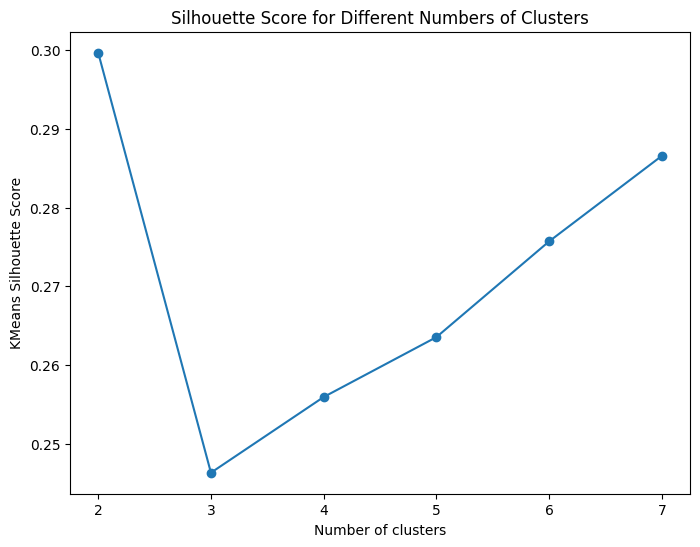

True

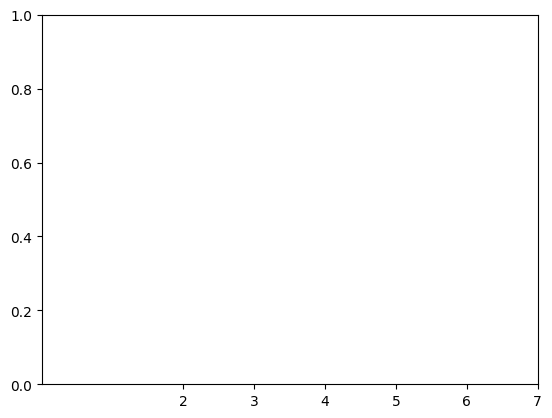

In [26]:
trace_silhouette_scores(visualize_silhouette_datas_all(path_antoine + "fusion_table_score_v1.csv",
                                                       ['Autres_n_REABOS', 'ODD 15 jours EV+_n_REABOS',
       'ODD 15 jours TC_n_REABOS', 'ODD 21 jours TC_n_REABOS',
       'ODD 30 jours EV+_n_REABOS', 'ODD 30 jours TC_n_REABOS',
       'ODD 7 jours autre que SG_n_REABOS', 'PAS_ODD_n_REABOS',
       'Semaine genéreuse_n_REABOS', 'PAS_ODD_MEAN_TIME', 'MOY_DELAI',
       'NB_APPARITIONS', 'Autres_MEAN_TIME_DIFF',
       'ODD 15 jours EV+_MEAN_TIME_DIFF', 'ODD 15 jours TC_MEAN_TIME_DIFF',
       'ODD 21 jours TC_MEAN_TIME_DIFF', 'ODD 30 jours EV+_MEAN_TIME_DIFF',
       'ODD 30 jours TC_MEAN_TIME_DIFF',
       'ODD 7 jours autre que SG_MEAN_TIME_DIFF', 'PAS_ODD_MEAN_TIME_DIFF',
       'Semaine genéreuse_MEAN_TIME_DIFF', 'Autres_n_REABOS_POURCENTAGE',
       'ODD 15 jours EV+_n_REABOS_POURCENTAGE',
       'ODD 15 jours TC_n_REABOS_POURCENTAGE',
       'ODD 21 jours TC_n_REABOS_POURCENTAGE',
       'ODD 30 jours EV+_n_REABOS_POURCENTAGE',
       'ODD 30 jours TC_n_REABOS_POURCENTAGE',
       'ODD 7 jours autre que SG_n_REABOS_POURCENTAGE',
       'Semaine genéreuse_n_REABOS_POURCENTAGE',
       'SCORE_FIDELITE'],
                                                       [2, 3, 4, 5,6,7],
                                                       path_antoine + "Clustering_results/Total/"), [2, 3, 4,5,6,7])